# Semantic segmentation with Deep Learning
Centrale Nantes

Diana Mateus

**Participants:** Saâd Aziz Alaoui, Yassine Jamoud, Samy Haffoudhi.

### Introduction

In many areas of biomedical research, cell counts obtained from images are crucial data for diagnosing patients or for addressing hypotheses about developmental or pathological processes. Although the field changes reapidly, many cell counts are still done manually or with semi-automatic tools. An automatic tool can therefore save time, reduce variability, and improve results. In this notebook we will model the problem in terms of semantic segmentation and approach it by means of deep learning, and more specifically with the U-Net architecture.

### 1. Load modules and data

#### 1.1 Import modules

In [1]:
#4S
# Import all the necessary libraries
import os
import datetime 
import glob                                           #filename pattern matching
import random
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#SKIMAGE
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
import skimage.exposure                               #Used for displaying 

#Tensorflow, Keras and related modules
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#To save and reload models
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import  plot_model


#Sklearn 
import sklearn
from sklearn.model_selection import train_test_split

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Tensorflow   :', tf.__version__)

2022-03-05 14:11:38.792425: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-05 14:11:38.792455: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Python       : 3.10.2 (main, Jan 15 2022, 19:56:27) [GCC 11.1.0]
Numpy        : 1.21.5
Skimage      : 0.19.1
Scikit-learn : 1.0.1
Tensorflow   : 2.8.0-rc1


#### 1.2 Import data 
Download data from

- https://box.ec-nantes.fr/index.php/s/X84Bq5NYJ2zJRpR (small dataset to begin with)
- https://box.ec-nantes.fr/index.php/s/oXAx37DbpXPDF7T (larger dataset for final tests single zip -> good internet connection)

#### 1.3 Define the data path
Define the data path and change the directory to the defined topDir. Also specify the train and test directories

In [2]:
#In case using colab
#from google.colab import drive

#drive.mount('/content/drive')

In [3]:
train_path = "stage1_train"#path to training data file/folder
test_path = "stage1_test" #path to test data file/folder

#### 1.4 Define global parameters
- Set seed for random values to a fix number (suggested: 42) to ensure that images are associated to the exactly corresponding masks . 
- Define the desired image size as two global parameters:
``` img_height, img_width ```. 
The defalut image size  is (64,64). You may want to reduce size for faster **debugging** or increase it (e.g. 256,256) for better results

In [4]:
#4S
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)

from tensorflow.random import set_seed
set_seed(42)

# Set number of GPUs
#num_gpus = 1   #defaults to 1 if one-GPU or one-CPU. If 4 GPUs, set to 4.

# Set height (y-axis length) and width (x-axis length) to train model on
img_height, img_width = (64,64)  #Default to (256,266), use (None,None) if you do not want to resize imgs

--------------------------------------------------------------------------
Nous verrons par la suite l'importance des paramètres de height et de width. En effet, si l'on prend img_height=img_width = 64, le temps d'execution est naturellement plus rapide mais les résultats obtenus sont moins bons que pour img_height=img_width = 256 qui lui prend un temps d'execution plus long.

#### 1.5 Read and preload the input image data
Read the data and create a tensor containing all the train and test data as well as their corresponding labels.

The following function ``get_images``  
- receives as input an image path (can be train or test), and a desired image shape for the output
- lists all files in the input image path. 
- reads each of the files with ``skimage.io.imread``
- uses ``skimage.transform.resize`` to directly downsample the images according to the ``img_height, img_width`` parameters.
- uses only the first three channels of the images.
- returns a numpy array (matrix) . 
- uses ``%%time`` to display the time spent in loading.

Run the function and print the shape and type of the resulting array (e.g. (670, 256, 256, 3) uint8 

In [5]:
%%time
# Get training data
def get_images(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    img_paths = ['{0}/{1}/images/{1}.png'.format(path, id) for id in os.listdir(path) if id != ".DS_Store"]

    #X_data = np.array([skimage.io.imread(path)[:,:,:3] for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands

    X_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:,:,:3], output_shape=output_shape, mode='constant', preserve_range=True) for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands
    
    return X_data

X_train = get_images(train_path, output_shape=(img_height,img_width))

print(X_train.shape, X_train.dtype)
    


(50, 64, 64, 3) uint8
CPU times: user 1.89 s, sys: 66.2 ms, total: 1.96 s
Wall time: 1.96 s


---------------------------------------------------------

Notons ici que les données de test de notre dataset ne contiennent que les images sans leurs vrais mask. Nous ne pourrons donc pas estimer numériquement l'exactitude de nos prédictions, nous ne pourrons que faire des analyses visuelles.

#### 1.6 Read and preload the expert annotation masks 
The following function ``get_labels``  
- receives as input a mask path (can be train or test), and a desired image shape for the output.
- lists all files in the input path. Hint: use ``os.listdir``.
- reads each of the files with ``skimage.io.imread``
- uses ``skimage.transform.resize`` to directly downsample the masks according to the ``img_height, img_width`` parameters.
- returns a numpy array (matrix) . Hint: define an ``np.array`` of type ``dtype=np.uint8`` to stock the data.
- uses ``%%time`` to display the time spent in loading.
- Runs the function and print the shape and type of the resulting array (e.g. (670, 256, 256, 3)) uint8 
- This can take some minutes (reduce the number of images to accelerate the first tests and reduce memory demands if necessary)

In [6]:
%%time
# Get training data labels
def get_labels(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    img_paths = [glob.glob('{0}/{1}/masks/*.png'.format(path, id)) for id in os.listdir(path) if id != ".DS_Store"]
    
    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)

    # make sure to return the binary images but coded as floats to be compatible with the loss functions
    Y_data = np.array(Y_data, dtype=np.bool)
    
    return Y_data    
    
Y_train = get_labels(train_path, output_shape=(img_height,img_width))

print("We have {} labeled images of size ({},{}) and type {}".format(Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],Y_train.dtype))




We have 50 labeled images of size (64,64) and type bool
CPU times: user 3.62 s, sys: 248 ms, total: 3.87 s
Wall time: 3.87 s


<timed exec>:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [7]:
Y_train =1.0*Y_train.astype(float)

#### 1.7 Visualize some examples of images and matching labels
Choose one index among the lists of images and labels and use ``plt.imshow`` to visualize side by side the corresponding image and mask.
You may want to use ```skimage.exposure.rescale_intensity``` for better visualization of the input.

Looking at image  38


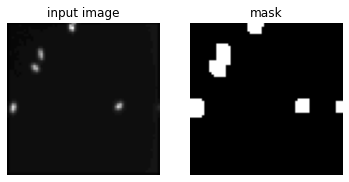

In [8]:
%matplotlib inline

idx = np.random.randint(Y_train.shape[0], size=1)[0]


print ('Looking at image ', idx)

plt.subplot(1,2,1)
plt.imshow(skimage.exposure.rescale_intensity(X_train[idx, :, :, :]))
plt.title('input image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(Y_train[idx, :, :],cmap='gray')
plt.title('mask')
plt.axis('off')

plt.show()

### 2. Buidling the U-Net model
#### 2.1. Define the architecture

The u-net is composed of an input layer, an encoder and a decoder. Both the encoder and deconder consists of several blocks with similar structure but different dimensions. Each encoder blocks is composed of two convolutional layers of the same dimensions with a pooling and an activation function. With pooling operations, the 2D dimensions of the image are progressively reduced; to compensate the number of filters (or equivalently of feature channels) in each block is increased. The decoder reverses the operations of the encoder. Finally skip connections are created between the encoder and the decoder. To make these connections  it is useful to create a list pointing to the output of each encoder block as well as a list pointing to the output of each decoder block.

**a)** Building the model
- Create a function ```model``` that receives as input the image size 
- Start by predefining as parameters within the function
    - the number of kernels/feature channels per block. Usually they have increasing powers of 2. For instance, ```n_channels=[16,32,64,128,256]```
    - a global kernel size ```(3,3)```
    - a weight initialization method (try `he_normal`)
- Create an input layer using the Keras function ``Input`` , the shape should match the the image dimensions.
- Declare the encoder blocks each composed of:
    - two convolutional layers. Use ``Conv2D``.
    - one maxpool layer (except for the last block). Use ``MaxPooling2D``
    - use relu activations
    - create a list pointing to each of the encoder blocks to be able to refer to them later while creating the skip connections
    - **Hint** Define one block of convolution+pool+relu then create a loop to iterate over the different blocks

- Define the decoder blocks each composed of:
    - one Transpose convolution layer.
    - two convolutional layers. 
    - use relu activations
    - create a list with pointing to each encoder blocks to be able to refer to them later the skip connections
    - **Hint** Define one block of transposed convolution+conv+relu then create a loop to iterate over the different blocks


- The output layer should be a Transpose convolution layer with a 'sigmoid' activatin and a 'glorot_normal' initialization

- Use the lists created above to create the skip connections 
    - connecting for each resolution the output of the encoder blocks to the input of the decoder blocks.

- Use the keras function ``Model`` to identify this function as the architecture and use the output of ```Model``` as the return value of the unet_model function


In [9]:
def unet_model(img_width=256, img_height=256):
    
    #define the architecture parameters
    n_channels = [16,32,64,128,256]  #the number of kernels/feature channels per block SELON TAILLE IMAGE ! 
    #n_channels = [2**i for i in range(4,int(np.log2(img_width)+1))]
    k_size = (3, 3)                  #size of filter kernel
    k_init = 'he_normal'             #kernel initializer
    encoder_list = []
    decoder_list = [] 
    
    initializer = tf.keras.initializers.HeNormal()

    
    
    # Use Keras Input layer to create one
    inp = Input(shape = (img_width,img_height,3))
    
    
    # Encoder
    conv_enc = inp
    for i in range(len(n_channels)):                           
        conv_1 = tf.keras.layers.Conv2D(n_channels[i], kernel_size = k_size, activation = "relu", padding='same')(conv_enc)
        conv_2 = tf.keras.layers.Conv2D(n_channels[i], kernel_size = k_size, activation = "relu", padding='same')(conv_1)
        encoder_list.append(conv_2)
        conv_enc = tf.keras.layers.MaxPool2D(pool_size=(2, 2) , strides = 2)(conv_2) 
        
    # Decoder
    conv_dec = conv_enc
    n_channels.reverse()
    for k in range(len(n_channels)):
        conv_3 = tf.keras.layers.Conv2DTranspose(n_channels[k],kernel_size = k_size, strides=2 , activation = "relu", padding='same')(conv_dec)
        decoder_list.append(conv_3)
        merge = add([conv_3, encoder_list[-k-1]])
        conv_4 = tf.keras.layers.Conv2D(n_channels[k], kernel_size = k_size, activation = "relu", padding='same')(merge)
        conv_dec = tf.keras.layers.Conv2D(n_channels[k], kernel_size = k_size, activation = "relu", padding='same')(conv_4)    
        
    # Output  
    outp = tf.keras.layers.Conv2DTranspose(1,kernel_size = k_size , kernel_initializer='glorot_normal',
                                           activation = "sigmoid", padding='same')(conv_dec)
    
    #outp = tf.keras.layers.Dropout(0.2)(outp)
    
    #Build Model with the architecture
    model = Model(inputs=[inp], outputs=[outp])
    
    return model

Pour cette architecture, on effectue la démarche classique définie dans la question.
Le modèle contient un input layer, un encoder et un decoder ainsi que des copy&crop qui permettent de sauter des étapes.
Pour définir le modèle, on effectue le choix arbitraire de réaliser deux boucles, la première ascendante selon la taille de n_channel, la deuxième descendante selon la taille de n_channel afin de simuler cette structure en U.

#### 2.2. Define the losses

Define and explain how to use the Dice coefficient and the binarry crossentropy as loss and metrics for the segmentation. Create a costum dice loss that is a weighted average between the two

In [10]:
def dice_coef(y_true, y_pred):
    score = 2 * (tf.math.reduce_sum(y_true * y_pred) / tf.math.reduce_sum(y_true + y_pred))
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)
    return loss

def costum_dice_loss(y_true, y_pred):
    loss = 0.5 * dice_loss(y_true, y_pred) + 0.5 * binary_crossentropy(y_true, y_pred)
    return loss

On définit ici les fonctions de loss avec les fonctions implémentées sur tf pour ne pas avoir de problèmes de compatibilité. 
On choisit arbitrairement des coefficients de 0.5 pour dice_loss et binary_crossentropy dans costum_dice_loss. On aurait pu mettre en entrée des paramètres a et b qui définissent les pourcentages entre les deux sous la forme : a * dice_loss(y_true, y_pred) + b * binary_crossentropy(y_true, y_pred)

#### 2.3 Define the optimizer 

In [11]:
# Set optmizer, loss and metric
optimizer = "adam"
loss      = costum_dice_loss
metrics   = "accuracy"

#### 2.4 Compile the model

In [12]:
#instantiate the model

model = unet_model(img_width, img_height)

#summary
model.summary()
#compile the model
model.compile(loss = loss , optimizer = optimizer, metrics=metrics)

2022-03-05 14:11:46.560342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-05 14:11:46.560373: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-05 14:11:46.560392: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arch): /proc/driver/nvidia/version does not exist
2022-03-05 14:11:46.560549: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   448         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 16)   2320        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 16)   0           ['conv2d_1[0][0]']               
                                                                                              

 conv2d_19 (Conv2D)             (None, 64, 64, 16)   2320        ['conv2d_18[0][0]']              
                                                                                                  
 conv2d_transpose_5 (Conv2DTran  (None, 64, 64, 1)   145         ['conv2d_19[0][0]']              
 spose)                                                                                           
                                                                                                  
Total params: 3,733,233
Trainable params: 3,733,233
Non-trainable params: 0
__________________________________________________________________________________________________


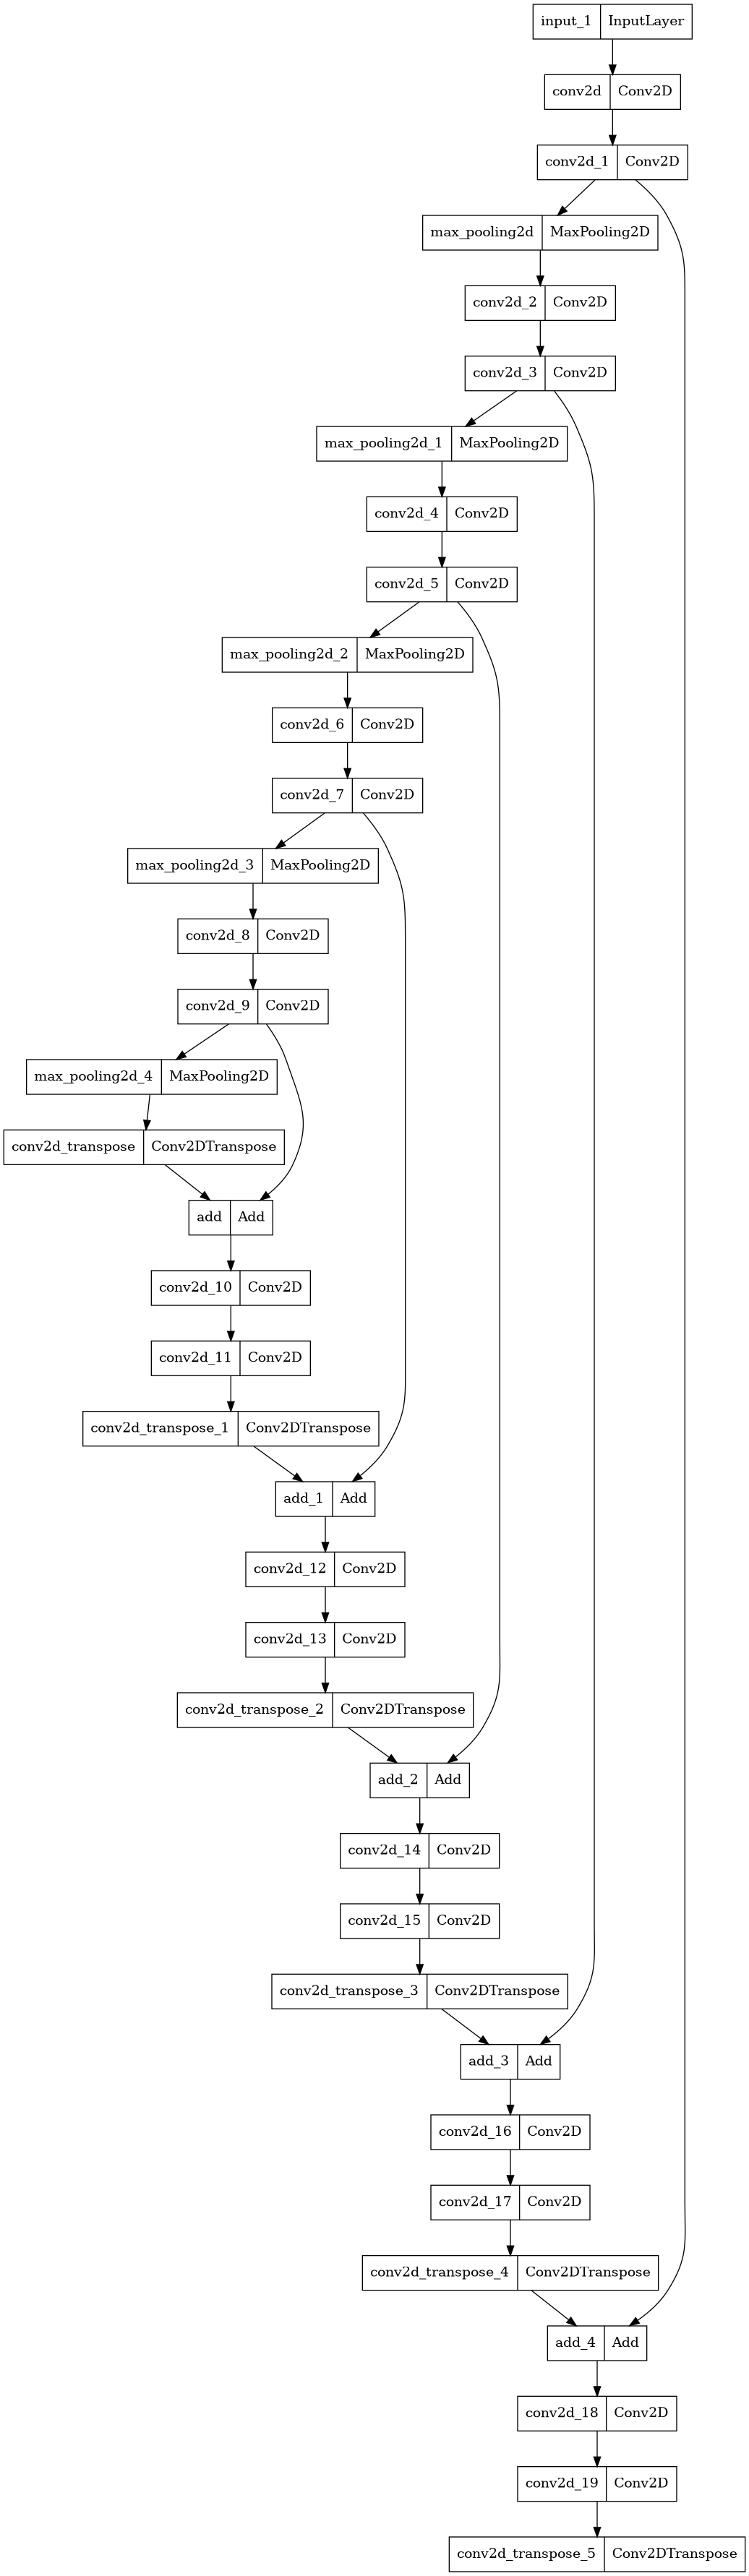

In [13]:
#run the following cell to visualize the created model

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

Cette partie nous permet de valider la structure de notre modèle. La visualisation donne bien cette forme en U que nous recherchons.

### 3. Trainning and testing

#### 3.1 Launch the training
- Use the ```model.fit``` function to launc the training, 
- save the output of the model.fit which provides the history of the training results. 
- Measure the overall time with ```%%time``` at the beginning of the notebook cell


In [14]:
%%time
# Fit model
epochs = 25

batch_size = 25

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/25
2/2 [==============================] - 2s 254ms/step - loss: 1.1325 - accuracy: 0.5706
Epoch 2/25
2/2 [==============================] - 1s 266ms/step - loss: 0.9686 - accuracy: 0.6132
Epoch 3/25
2/2 [==============================] - 1s 251ms/step - loss: 0.7171 - accuracy: 0.5066
Epoch 4/25
2/2 [==============================] - 1s 261ms/step - loss: 0.6813 - accuracy: 0.6679
Epoch 5/25
2/2 [==============================] - 1s 260ms/step - loss: 0.6613 - accuracy: 0.6043
Epoch 6/25
2/2 [==============================] - 1s 266ms/step - loss: 0.6284 - accuracy: 0.6838
Epoch 7/25
2/2 [==============================] - 1s 269ms/step - loss: 0.5998 - accuracy: 0.7154
Epoch 8/25
2/2 [==============================] - 1s 254ms/step - loss: 0.5906 - accuracy: 0.6681
Epoch 9/25
2/2 [==============================] - 1s 266ms/step - loss: 0.5874 - accuracy: 0.6847
Epoch 10/25
2/2 [==============================] - 1s 254ms/step - loss: 0.5720 - accuracy: 0.7432
Epoch 11/25
2/2 [==

-----------------------------------------------------------------------------

On remarque naturellement ici l'impact de img_width et img_height. Plus ces deux derniers sont grands, plus la fonction prend du temps à se lancer. Ce premier impact nous induit sur l'idée que pour débugger nos fonctions, il serait plus intéressant de travailler en (64,64) tout au long du TP et de modifier les valeurs en (256,256) à la fin pour analyser nos valeurs numériques.

**Temps d'exécution** sur notre machine : 

(64,64) = 0.6s / step
(256,256) = 8s / step

Ceci dépend bien évidemment de la machine sur laquelle on travaille, mais la comparaison reste la même.

In [15]:
score = model.evaluate(X_train, Y_train, verbose=0)
print("Train accuracy:", score[1])

Train accuracy: 0.9053271412849426


Puisque nous ne définissons pas de seed dans la fonction, la valeur de train_acc varie à chaque fois qu'on lance notre code. Disons que nous obtenons en moyenne une valeur de train_acc = 0.91 et que la fonction de loss décroît raisonnablement.
Les valeurs nous permettent de conclure sur le bon fonctionnement de notre modèle pour la partie train.

#### 3.2. Save the model
Save the final model ``model_out.save_weights`` with an hdf5 format. 

In [16]:
model.save_weights('model1_weights.hdf5')

#### 3.3. Plot the loss and the metrics

from the output of the fit function

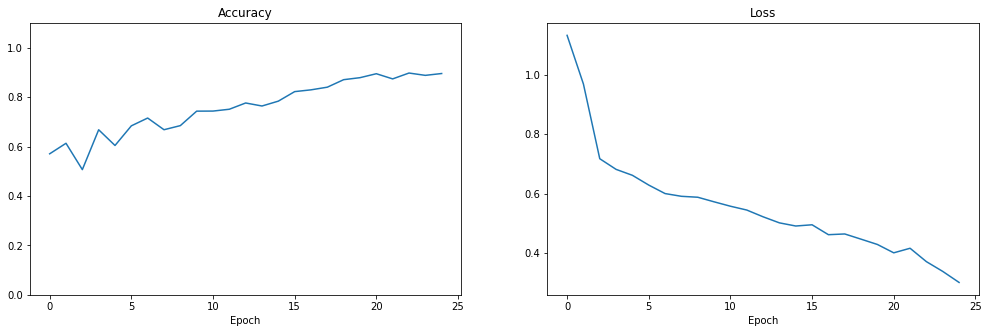

In [17]:
plt.figure(figsize=(17,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1.1])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('Epoch')

plt.show()

L'accuracy converge bien vers 1 et la fonction de loss décroît convenablement. On peut varier les paramètres **epochs** et **batch_size**. Augmenter **epochs** nous permettra d'obtenir de meilleurs valeurs jusqu'à un certain seuil d'overfit qui baissera l'efficacité du modèle. 
En ce qui concerne **batch_size**, c'est le paramètre qui définit le nombre de samples qui seront propagés dans le réseau.
On retrouve les défauts et atouts principaux de choisir un batch_size < nombre de tous les samples dans ce modèle.   
**Batch_size < nombre de tous les samples dans ce modèle:**  
    **Avantages:**  
    - Ça demande moins de mémoire et le train est plus rapide car on réinitialise les poids après chaque propagation    
    **Défauts:**
    - Plus le batch est faible, plus l'estimation du gradient est mauvaise
    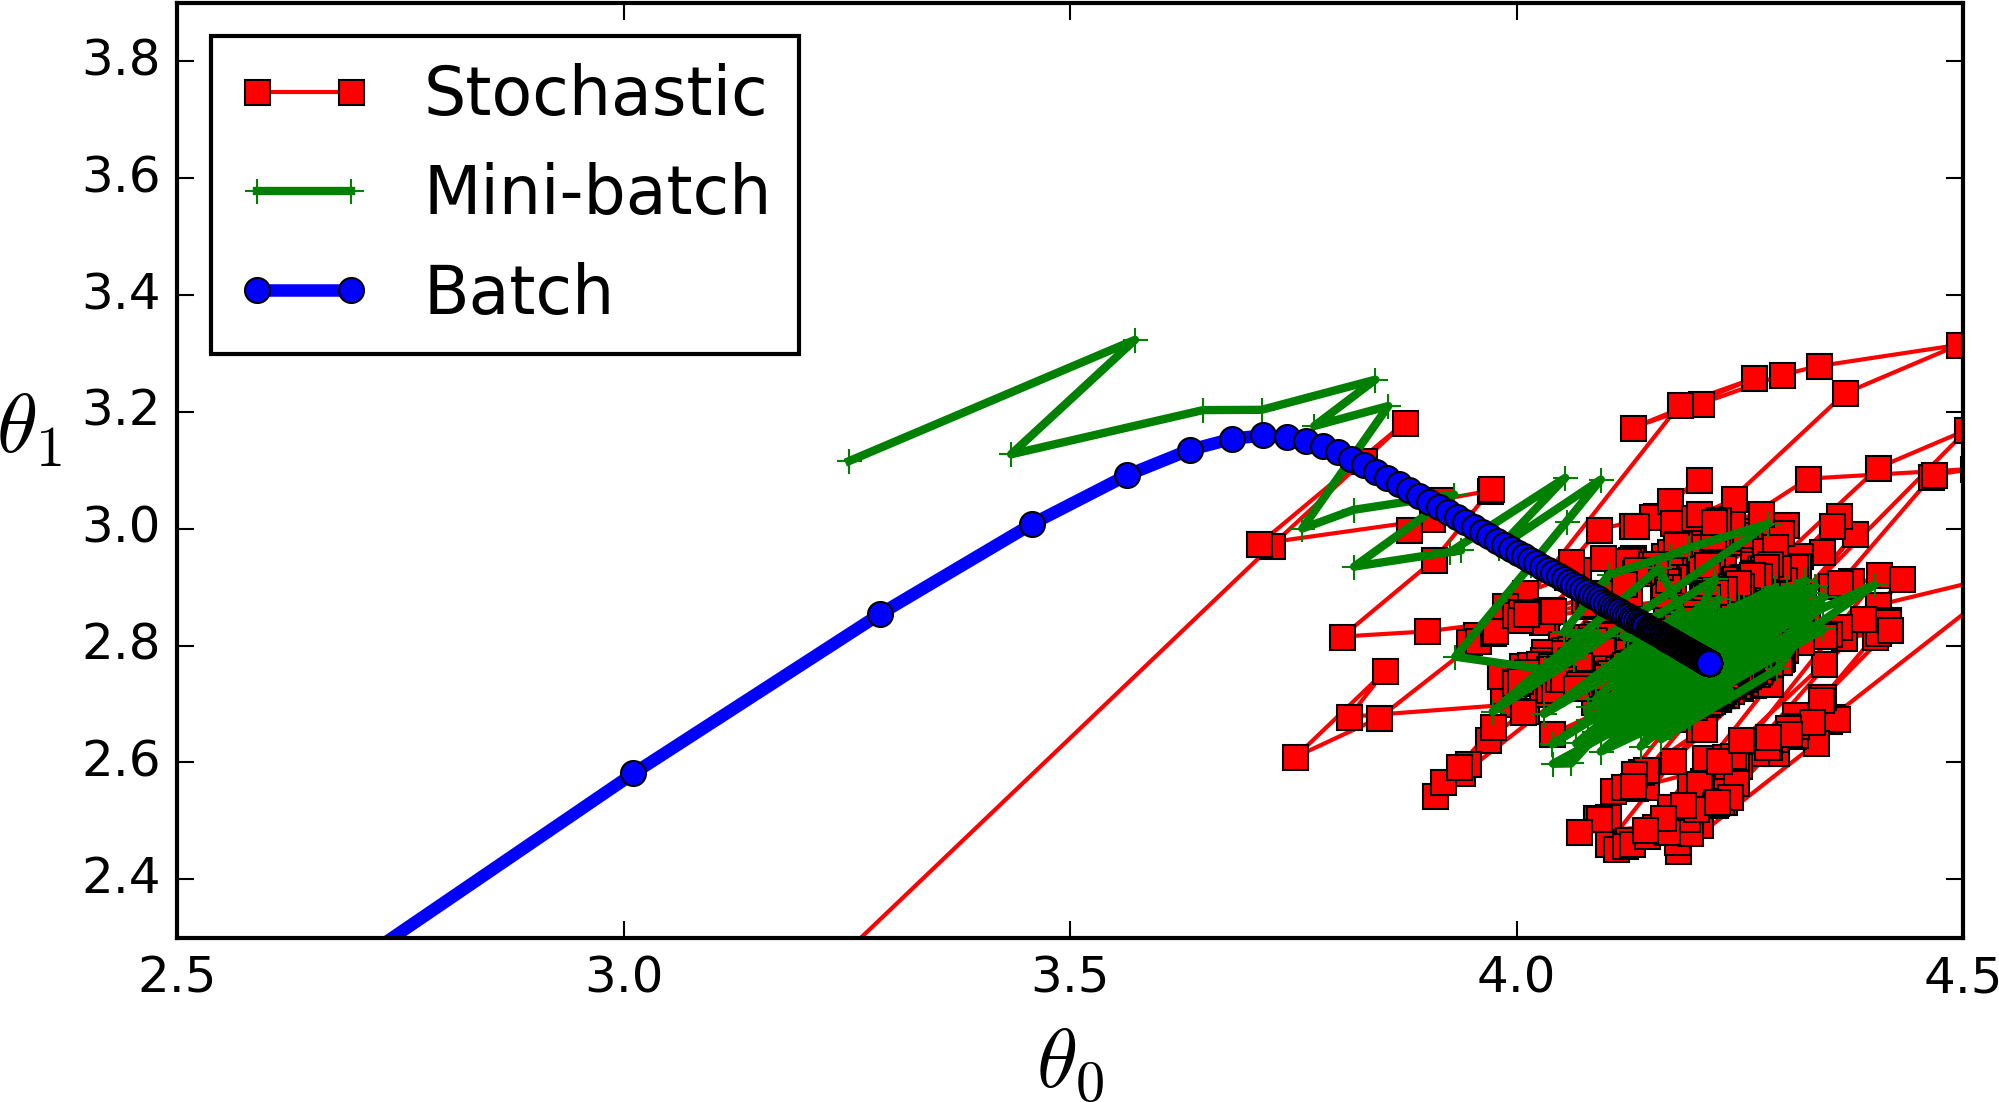

#### 3.4. Test
Load the test images, make predictions and visualize the predictions 



In [18]:
X_test = get_images(test_path, output_shape=(img_height,img_width))
print(X_test.shape, X_test.dtype)

(10, 64, 64, 3) uint8


In [19]:
# if required reload the model
model.load_weights('model1_weights.hdf5')

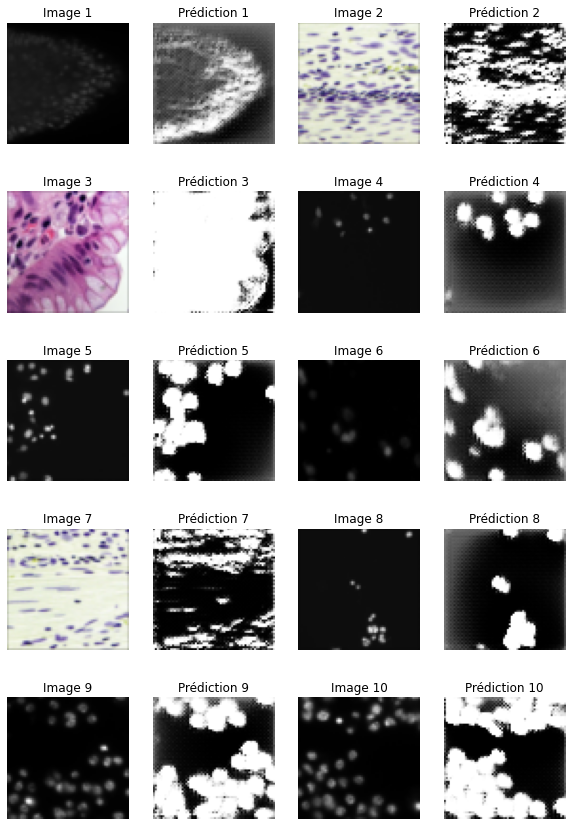

In [20]:
plt.figure(figsize=(10,15))

prediction = model.predict(X_test)

plt_counter = 1

for i in range(X_test.shape[0]):
    plt.subplot(5, 4, plt_counter)
    plt.imshow(X_test[i])
    plt.title(f'Image {i+1}')
    plt.axis('off')
    
    plt.subplot(5, 4, plt_counter + 1)
    plt.imshow(prediction[i], cmap='gray')
    plt.title(f'Prédiction {i+1}')
    plt.axis('off')
    
    plt_counter += 2

plt.savefig("test_1")
plt.show()

-------------------------------------------------------------------------------------------
On obtient ici nos premiers résultats en image pour le premier modèle.  
On observe des résultats assez convaincants. En effet, comme précisé au tout début, nous n'avons pas les vrais masks donc on ne peut faire que des comparaisons visuelles. Ici, les masks sont souvent assez corrects en comparaison avec les images.   
On aurait pu mettre toutes les images en grayscale pour mieux comparer visuellement, mais ça n'aurait pas eu un grand effet.

### 4 Comparison and Improvement

Try making changes to improve the results. Do at least one of the following modifications 
- Change the architecture (use the one from the tf example, or add other types of layers (e.g. dropout) or non-linarities (e.g. leaky relu) and compare the training curves
- add data augmentation (rotation, flip, translation of each image)
- add an explicit validation set and ilustrate the intermediate results and metrics on the validation set
- add data generators (to sample and augment data online)





In [21]:
def unet_model_enhanced(img_width=256, img_height=256):
    
    #define the architecture parameters
    n_channels = [16,32,64,128,256]  #the number of kernels/feature channels per block SELON TAILLE IMAGE ! 
    #n_channels = [2**i for i in range(4,int(np.log2(img_width)+1))]
    k_size = (3, 3)                  #size of filter kernel
    k_init = 'he_normal'             #kernel initializer
    encoder_list = []
    decoder_list = [] 
    
    initializer = tf.keras.initializers.HeNormal()

    
    
    # Use Keras Input layer to create one
    inp = Input(shape = (img_width,img_height,3))
    
    # Encoder
    conv_enc = inp
    for i in range(len(n_channels)):                           
        conv_1 = tf.keras.layers.Conv2D(n_channels[i], kernel_size = k_size, activation = "relu", padding='same')(conv_enc)
        conv_2 = tf.keras.layers.Conv2D(n_channels[i], kernel_size = k_size, activation = "relu", padding='same')(conv_1)
        encoder_list.append(conv_2)
        conv_enc = tf.keras.layers.MaxPool2D(pool_size=(2, 2) , strides = 2)(conv_2) 
        
    # Decoder
    conv_dec = conv_enc
    n_channels.reverse()
    for k in range(len(n_channels)):
        conv_3 = tf.keras.layers.Conv2DTranspose(n_channels[k],kernel_size = k_size, strides=2 , activation = "relu", padding='same')(conv_dec)
        decoder_list.append(conv_3)
        merge = add([conv_3, encoder_list[-k-1]])
        conv_4 = tf.keras.layers.Conv2D(n_channels[k], kernel_size = k_size, activation = "relu", padding='same')(merge)
        conv_dec = tf.keras.layers.Conv2D(n_channels[k], kernel_size = k_size, activation = "relu", padding='same')(conv_4)    
        
    # Output  
    outp = tf.keras.layers.Conv2DTranspose(1,kernel_size = k_size , kernel_initializer='glorot_normal',
                                           activation = "sigmoid", padding='same')(conv_dec)
    
    #outp = tf.keras.layers.Dropout(0.2)(outp)
    
    #Build Model with the architecture
    model = Model(inputs=[inp], outputs=[outp])
    
    return model

In [22]:
#instantiate the model

model_enhanced = unet_model_enhanced(img_width, img_height)

#summary
model_enhanced.summary()
#compile the model
model_enhanced.compile(loss = loss , optimizer = optimizer, metrics=metrics)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 64, 64, 16)   448         ['input_2[0][0]']                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 64, 64, 16)   2320        ['conv2d_20[0][0]']              
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 32, 32, 16)  0           ['conv2d_21[0][0]']              
                                                                                            

 conv2d_39 (Conv2D)             (None, 64, 64, 16)   2320        ['conv2d_38[0][0]']              
                                                                                                  
 conv2d_transpose_11 (Conv2DTra  (None, 64, 64, 1)   145         ['conv2d_39[0][0]']              
 nspose)                                                                                          
                                                                                                  
Total params: 3,733,233
Trainable params: 3,733,233
Non-trainable params: 0
__________________________________________________________________________________________________


In [23]:
epochs = 25
batch_size = 25

In [24]:
def data_augmentation(X, Y, validation_split=0.1, seed=seed, batch_size=batch_size):
    
    X_train, X_val, Y_train, Y_val = train_test_split(X, 
                                                      Y, 
                                                      train_size =1-validation_split, 
                                                      test_size=validation_split, 
                                                      random_state=seed)
    
    data_gen_args = dict(rotation_range = 45.,
                     width_shift_range = 0.1,
                     height_shift_range = 0.1,
                     horizontal_flip = True,
                     vertical_flip = True)

    X_datagen = ImageDataGenerator(**data_gen_args)
    y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    y_datagen.fit(Y_train, augment=True, seed=seed)
    X_augmented_train = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_augmented_train = y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
    
    X_datagen_val = ImageDataGenerator()
    y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_val, augment=True, seed=seed)
    y_datagen_val.fit(Y_val, augment=True, seed=seed)
    X_augmented_val = X_datagen_val.flow(X_val, batch_size=batch_size, shuffle=True, seed=seed)
    Y_augmented_val = y_datagen_val.flow(Y_val, batch_size=batch_size, shuffle=True, seed=seed)

    return zip(X_augmented_train, Y_augmented_train), zip(X_augmented_val, Y_augmented_val)

train_gen, val_gen = data_augmentation(X_train, Y_train)

Pour l'amélioration du modèle, on choisit de faire une data augmentation avec une validation explicite et résultats intermédiaires. On a essayé d'ajuster légèrement le modèle mais cela ne changeait pas grandement l'efficacité. On a décidé de retirer alors ces modifications.

In [25]:
%%time

# Fit model
history_enhanced = model_enhanced.fit(train_gen, 
                                      epochs=epochs, 
                                      validation_data=val_gen,
                                      validation_steps=batch_size,
                                      steps_per_epoch=len(X_train)//batch_size)

Epoch 1/25
2/2 [==============================] - 2s 826ms/step - loss: 1.9903 - accuracy: 0.4450 - val_loss: 0.7682 - val_accuracy: 0.5972
Epoch 2/25
2/2 [==============================] - 1s 592ms/step - loss: 0.8879 - accuracy: 0.4614 - val_loss: 0.8467 - val_accuracy: 0.4512
Epoch 3/25
2/2 [==============================] - 1s 621ms/step - loss: 0.7886 - accuracy: 0.5249 - val_loss: 0.7808 - val_accuracy: 0.6719
Epoch 4/25
2/2 [==============================] - 1s 619ms/step - loss: 0.8171 - accuracy: 0.6223 - val_loss: 1.0328 - val_accuracy: 0.3872
Epoch 5/25
2/2 [==============================] - 1s 663ms/step - loss: 0.8149 - accuracy: 0.3172 - val_loss: 0.6926 - val_accuracy: 0.6397
Epoch 6/25
2/2 [==============================] - 1s 643ms/step - loss: 0.7027 - accuracy: 0.6328 - val_loss: 0.6640 - val_accuracy: 0.6893
Epoch 7/25
2/2 [==============================] - 1s 663ms/step - loss: 0.6855 - accuracy: 0.6733 - val_loss: 0.6766 - val_accuracy: 0.6291
Epoch 8/25
2/2 [====

In [26]:
score = model_enhanced.evaluate(X_train, Y_train, verbose=0)
print("Train accuracy:", score[1])

Train accuracy: 0.8518456816673279


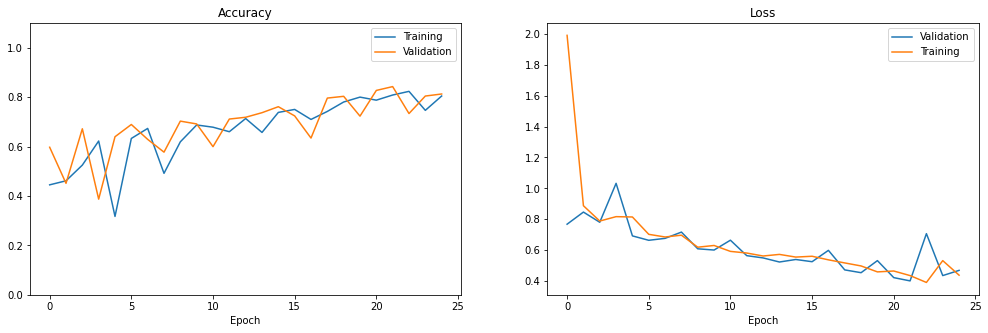

In [27]:
plt.figure(figsize=(17,5))

plt.subplot(1, 2, 1)
plt.plot(history_enhanced.history['accuracy'], label='Training')
plt.plot(history_enhanced.history['val_accuracy'], label='Validation')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1.1])

plt.subplot(1, 2, 2)
plt.plot(history_enhanced.history['val_loss'], label='Validation')
plt.plot(history_enhanced.history['loss'], label='Training')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')

plt.show()

On observe que :

* Les courbes de précision croissent et tendent aux alentours de 0.8
* Les courbes de coût décroissent
* Les courbes sont très similaires entre l'ensemble de validation et de d'entrainement, notre modèle généralise bien.

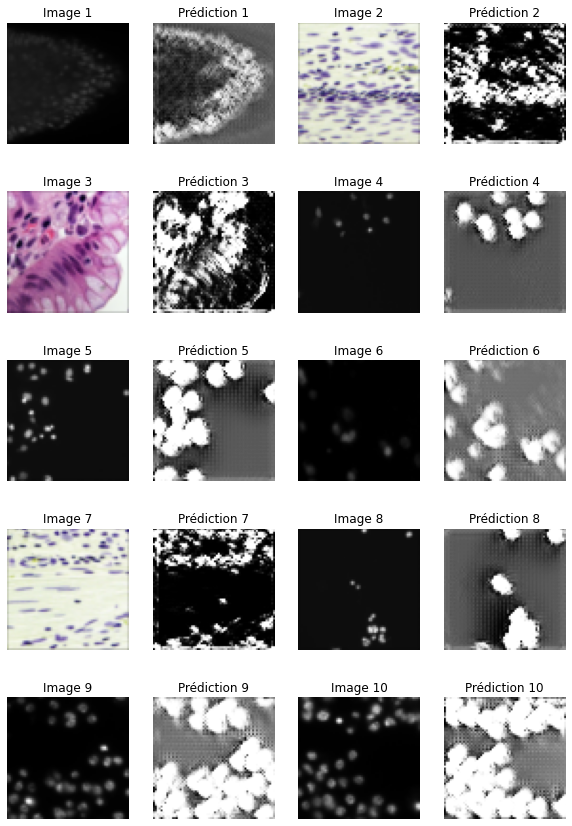

In [30]:
plt.figure(figsize=(10,15))

prediction = model_enhanced.predict(X_test)

plt_counter = 1

for i in range(X_test.shape[0]):
    plt.subplot(5, 4, plt_counter)
    plt.imshow(X_test[i])
    plt.title(f'Image {i+1}')
    plt.axis('off')
    
    plt.subplot(5, 4, plt_counter + 1)
    plt.imshow(prediction[i], cmap='gray')
    plt.title(f'Prédiction {i+1}')
    plt.axis('off')
    
    plt_counter += 2

plt.savefig('test_2.png')
plt.show()

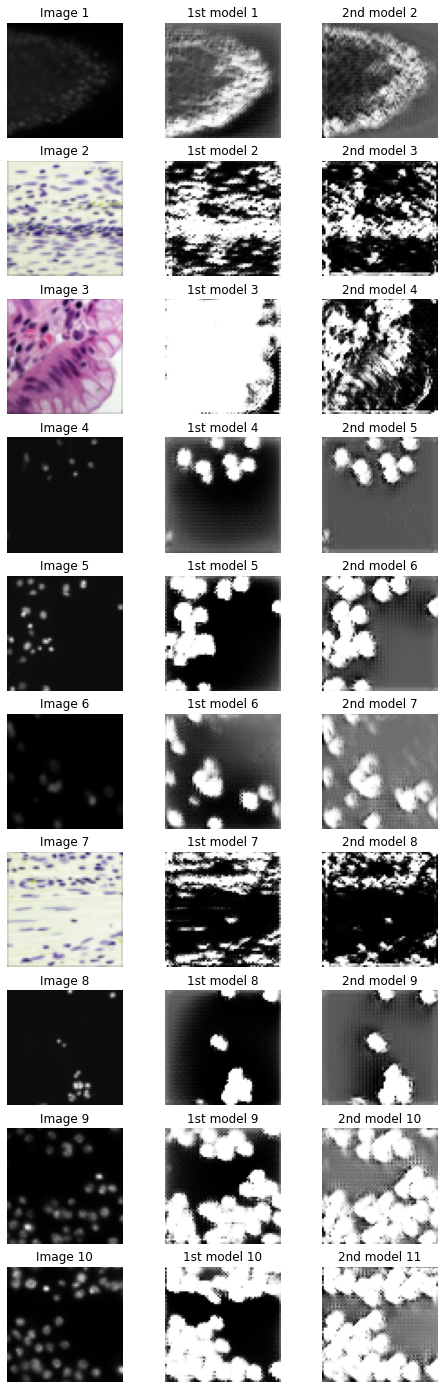

In [32]:
plt.figure(figsize=(8,25))

prediction_enhanced = model_enhanced.predict(X_test)
prediction = model.predict(X_test)

plt_counter = 1

for i in range(X_test.shape[0]):
    plt.subplot(10, 3, plt_counter)
    plt.imshow(X_test[i])
    plt.title(f'Image {i+1}')
    plt.axis('off')
    
    plt.subplot(10, 3, plt_counter + 1)
    plt.imshow(prediction[i], cmap='gray')
    plt.title(f'1st model {i+1}')
    plt.axis('off')
    
    plt.subplot(10, 3, plt_counter + 2)
    plt.imshow(prediction_enhanced[i], cmap='gray')
    plt.title(f'2nd model {i+2}')
    plt.axis('off')
    
    plt_counter += 3

plt.savefig('comparaison.png')
plt.show()

On montre ici la comparaison entre les résultats du premier modèle et du deuxième pour 10 images différentes. On remarque directement que le deuxième modèle est légèrement plus performant que le premier. Pour l'image 3 qui est assez complexe par exemple, on voit que l'on a pas un amas de blanc pour le mask mais bien des courbures en bas à droite :  
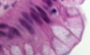

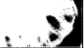

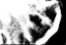    

Cependant, on voit sur l'exemple de l'image 10 par exemple que c'est le modèle 2 qui grossit légèrement les traits.
Disons que de manière globale, le modèle 2 est plus performant même si les fonds fournis par le premier sont génèralement plus noirs. Notre amélioration de modèle est bien effective mais peut encore être améliorée.







**CONCLUSION**

En conclusion, nous avons pu nous entraîner sur l'architecture U-net de deep learning.   
Nous avons pu voir que l'encodeur réduit les dimensions spatiales dans chaque couche et augmente les canaux. D'autre part, le décodeur augmente les dimensions spatiales tout en réduisant les canaux.  
Ces types de modèles sont extrêmement utilisés dans les applications du monde réel comme on a pu le voir.
Notre amélioration du modèle nous prouve qu'il y'a encore beaucoup de travail à faire sur l'optimisation des paramètres de ces modèles et que leur capacité d'expansion semble un peu infinie. 